## Import libraries

In [1]:
# Import Libraries 
library(tidyverse)
library(janitor)
library(stringr)
library(lubridate)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'janitor'


The following objects are masked from 'package:stats':

    chisq.test, fisher.test



Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union




## Import data and create dataframes

In [ ]:
# Documenting Steps for Downloading Data Files

# Salary file
#python download_data.py --url=https://github.com/invinst/chicago-police-data/blob/master/data/unified_data/salary/salary-ranks_2002-2017_2017-09.csv.gz?raw=true --path=../data/salary.csv

# Accused file
#python download_data.py --url=https://github.com/invinst/chicago-police-data/blob/master/data/unified_data/complaints/complaints-accused.csv.gz?raw=true --path=../data/accused.csv

# Complaints file
#python download_data.py --url=https://github.com/invinst/chicago-police-data/blob/master/data/unified_data/complaints/complaints-complaints.csv.gz?raw=true --path=../data/complaints.csv

# Demographics file 
#python download_data.py --url=https://github.com/invinst/chicago-police-data/blob/master/data/unified_data/profiles/final-profiles.csv.gz?raw=true --path=../data/demographics.csv

In [2]:
# Load csv files.  Readin all columns as characters, eliminates issues with formatting (some cr_id were defaulting to NA)
accused_df <- read_csv("../data/accused.csv", col_type = paste(rep("c",10),collapse = ""))
complaints_df <- read_csv("../data/complaints.csv", col_type = paste(rep("c",11),collapse = ""))
salary_df <- read_csv("../data/salary.csv", col_types = paste(rep("c",8),collapse = ""))
demographics_df <- read_csv("../data/demographics.csv", col_types = paste(rep("c",20), collapse = ""))

In [3]:
# See first few rows of DFs
head(accused_df)
head(complaints_df)
head(salary_df)
head(demographics_df)

UID,complaint_category,complaint_code,cr_id,cv,final_finding,final_outcome,recc_finding,recc_outcome,link_UID
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
130469.0,SUPERVISOR RESPONSIBILITY: FAIL TO OBTAIN COMPLAINT REGISTER NO.,12D,C170981,1,NS,NO ACTION TAKEN,NA,NA,20040.0
103495.0,EXCESSIVE FORCE: ARRESTEE - DURING ARREST,05A,C170981,1,NS,NO ACTION TAKEN,NA,NA,7727.0
111845.0,EXCESSIVE FORCE: ARRESTEE - DURING ARREST,05A,C170981,1,NS,NO ACTION TAKEN,NA,NA,17149.0
126148.0,EXCESSIVE FORCE: ARRESTEE - DURING ARREST,05A,C170981,1,NS,NO ACTION TAKEN,NA,NA,271.0
127906.0,EXCESSIVE FORCE: ARRESTEE - DURING ARREST,05A,C170981,1,NS,NO ACTION TAKEN,NA,NA,11004.0
117100.0,EXCESSIVE FORCE: NO ARREST,05D,C171131,1,EX,NO ACTION TAKEN,NA,NA,25023.0


cr_id,cv,incident_date,complaint_date,closed_date,add1,add2,beat,city,full_address,location
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1000194,2,2006-10-02,2006-10-02,NA,7809,S SOUTH SHORE DR,421.0,CHICAGO IL,NA,17
1000214,3,2006-10-03,2006-10-04,2010-12-23,7100,South WESTERN AVE,832.0,CHICAGO ILLINOIS 60636,NA,NA
1002796,3,2006-12-15,2007-01-18,2008-12-15,325,North JEFFERSON ST,1212.0,CHICAGO ILLINOIS 60661,NA,TAVERN/LIQUOR STORE
1003786,3,2007-03-01,2007-03-02,2011-02-23,NA,West 87TH ST,834.0,CHICAGO ILLINOIS 60652,NA,RESIDENCE
1005070,2,2007-04-20,2007-04-20,NA,4010,W ERIE ST,0.0,CHICAGO IL,NA,17
1005436,2,2005-05-15,2007-05-04,NA,4427,S KARLOV AVE,815.0,CHICAGO IL 60632,NA,17


UID,pay_grade,rank,salary,year,spp_date,cleaned_rank,link_UID
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
100011.0,E|3,SERGEANT,101442.0,2016.0,2016-02-01,SERGEANT,3978.0
100013.0,E|3,SERGEANT,111474.0,2016.0,2016-06-01,SERGEANT,4443.0
100014.0,D|2A,POLICE OFFICER (ASSIGNED AS DETECTIVE),76446.0,2007.0,2007-04-01,DETECTIVE,4879.0
100027.0,E|3,SERGEANT,98184.0,2016.0,2016-06-01,SERGEANT,16115.0
100044.0,D|2,POLICE OFFICER (ASSIGNED AS EVIDENCE TECHNICIAN),61518.0,2004.0,2004-12-01,POLICE OFFICER,38.0
100054.0,D|2,POLICE OFFICER/EXPLSV DETECT K9 HNDLR,87048.0,2011.0,2011-06-16,POLICE OFFICER,9432.0


UID,first_name,last_name,middle_initial,middle_initial2,suffix_name,birth_year,race,gender,appointed_date,resignation_date,current_status,current_star,current_unit,current_rank,start_date,org_hire_date,profile_count,cleaned_rank,link_UID
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
100001,A,BRODERSON,F,NA,NA,1926.0,WHITE,MALE,1950-06-03,1980-03-10,0.0,NA,NA,NA,NA,NA,3,NA,2863.0
100002,A,DALESSANDRO,A,NA,NA,1923.0,WHITE,MALE,1956-09-01,1979-10-18,0.0,NA,NA,NA,NA,NA,3,NA,6100.0
100003,A,KIBURAS,J,NA,NA,1948.0,WHITE,MALE,1968-06-24,1980-10-01,0.0,NA,NA,NA,NA,NA,3,NA,14560.0
100004,A,KUSTRA,J,NA,NA,1923.0,WHITE,MALE,1953-09-28,1980-10-01,0.0,NA,NA,NA,NA,NA,3,NA,15445.0
100005,A,MC LAUGHLIN,R,NA,NA,1941.0,BLACK,MALE,1966-06-20,1986-09-16,0.0,NA,123.0,POLICE OFFICER,NA,NA,3,POLICE OFFICER,18373.0
100006,A RICHARD,LABRIOLA,NA,NA,NA,1943.0,WHITE,MALE,1971-10-25,2004-03-15,0.0,NA,8.0,POLICE OFFICER,NA,NA,7,POLICE OFFICER,15521.0


## Check for duplicates

### Process
There are several duplicate complaints in the accused and complaints dataset, the `cr_id` sometimes appears with "CR" as the suffix and sometimes it does not.  Unclear as to why this occurs, from what I can tell the remainder of the information is either identical or very similar (i.e. updated wording, all caps vs no caps).    There are 20,108 rows of duplicate accused. 

To confirmed duplicates:
1. Created new `cr_id_num` to remove suffix
2. Used `janitor::get_dupes()` function to isolate any duplicates.  Considered if there was duplicates due to several officers named in complaint, these are not considered duplicates. 
3. Counted number of rows. 

#### Accused dataframe

In [4]:
## Check for duplicates in the accused dataset

accused_duplicates <- accused_df %>% 
    mutate(cr_id_num = str_match(cr_id,"[0-9]+")) %>%
    get_dupes(cr_id_num, UID)

Appears that all the duplicates are split between `cv == 1` (10054 records) and `cv == 2 | 3` (10054 records).   However there are other non-duplicate records where `cv == 2 | 3` in the imported dataset, so we can't filter only on `cv`.  

Per the data dictionary: "cv: version of complaints where row originated (1 = 1967-1999, 2 = 2000-2016, 3 = 2000 - 2018)".  We will keep the latest version of the complaint, i.e. `cv == 2 | 3`. 

In [5]:
## filter to include on `cv == 1` this will then be used to remove these records from the imported accused dataset
accused_duplicates_to_remove <- accused_duplicates %>%
    filter(cv == 1)
nrow(accused_duplicates_to_remove)

[1] 10054

In [6]:
# remove duplicate records from accused dataframe
accused_df_deduplicated <- accused_df %>% 
    anti_join(accused_duplicates_to_remove, by = c("cr_id", "UID"))

#### Complaints Dataframe

In [7]:
## Check for duplicates in the complaints dataset

complaints_duplicates <- complaints_df %>% 
    mutate(cr_id_num = str_match(cr_id,"[0-9]+")) %>%
    get_dupes(cr_id_num)

We see a similar pattern with the complaints dataframe.  Exclude duplicates with `cv = 1` for consistency

In [8]:
## filter to include on `cv == 1` this will then be used to remove these records from the imported complaints dataset
complaints_duplicates_to_remove <- complaints_duplicates %>%
    filter(cv == 1)
nrow(complaints_duplicates_to_remove)

[1] 6436

In [9]:
# remove duplicate records from complaints dataframe
complaints_df_deduplicated <- complaints_df %>% 
    anti_join(complaints_duplicates_to_remove, by = c("cr_id"))

### Demographics Dataframe 

In [10]:
# Code to clean demographics dataframe 
# Note 1: only relevant columns were selected
# Note 2: Org_start_date = date as officer, start_date = date as officer in CPD.

demographics_df <- demographics_df %>%  
    select(UID, link_UID, race, gender, birth_year, cleaned_rank, 
           org_hire_date, start_date, resignation_date) %>% 
    mutate(birth_year = as.numeric(birth_year),
           org_hire_date= ymd(org_hire_date),
           start_date= ymd(start_date),
           resignation_date= ymd(resignation_date))

## Join Dataframes

In [11]:
# Join complaints, modify datatypes & filter on years of interest
complaints_joined = left_join(accused_df_deduplicated, complaints_df_deduplicated, by = 'cr_id')

complaints_joined <- complaints_joined %>%
     mutate(incident_date = ymd(incident_date),
           complaint_date = ymd(complaint_date),
           closed_date = ymd(closed_date),
           incident_year = year(incident_date)) %>%
    filter(incident_year >= 2005, incident_year <= 2015) %>%
    group_by(link_UID, incident_year) %>%
    nest() %>%
    mutate(complaints_per_year =  map_dbl(data, ~sum(!is.na(.$cr_id))))

In [12]:
#Modify salary datatypes and filter on years of interest
salary_df <- salary_df %>%
    mutate(year = as.numeric(year),
           spp_date = ymd(spp_date),
           salary = as.numeric(salary)) %>%
    filter(year >= 2005, year <= 2015)
           
#Join salaries and joint complaints
df_merged <- full_join(salary_df, complaints_joined, by = c('link_UID', c("year" = "incident_year")))

# Join demographics to merged datadrame
df_merged_demographics <- left_join(df_merged, demographics_df, by = c('link_UID', "cleaned_rank"))

# add ordering for rank senority - adapted from http://directives.chicagopolice.org/directives/data/a7a57be2-1291da66-88512-91e3-fb25744de048d4ef.html
# also referenced https://en.wikipedia.org/wiki/Police_rank#United_States
rank_order = c("DEPUTY SUPERINTENDENT", "FIRST DEPUTY SUPERINTENDENT", 
            "ASSISTANT SUPERINTENDENT", "SUPERINTENDENT\'S CHIEF OF STAFF", "GENERAL COUNSEL", "CHIEF", "DEPUTY CHIEF", "COMMANDER", 
            "SERGEANT", "DETECTIVE", "INVESTIGATOR", "FIELD TRAINING OFFICER", "POLICE OFFICER", "CIVILIAN")

# clean final df
complaints_all_staff <- df_merged_demographics %>%
    drop_na(salary) %>%                                                # remove records where no salary information was avaiable
    select(-rank, - pay_grade, -spp_date, -UID.x, -UID.y) %>%          # drop columns not used in analysis
    mutate(approx_age = year - birth_year, approx_years_service = year - year(start_date)) %>% # calculate approximate age and approximate years of service
    mutate(cleaned_rank = factor(cleaned_rank, levels = rank_order)) %>%   # change to factor
    mutate(complaints_per_year = if_else(is.na(complaints_per_year), 0, complaints_per_year))

# Examine all columns of analysis dataframe
glimpse(complaints_all_staff)

Rows: 143,280
Columns: 14
$ salary               <dbl> 76446, 87048, 99444, 90540, 99756, 97212, 8215...
$ year                 <dbl> 2007, 2011, 2014, 2013, 2012, 2015, 2008, 2013...
$ cleaned_rank         <fct> DETECTIVE, POLICE OFFICER, SERGEANT, DETECTIVE...
$ link_UID             <chr> "4879.0", "9432.0", "21388.0", "24345.0", "119...
$ data                 <list> [NULL, NULL, NULL, <tbl_df[1 x 19]>, NULL, NU...
$ complaints_per_year  <dbl> 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0...
$ race                 <chr> "BLACK", "HISPANIC", "HISPANIC", "HISPANIC", "...
$ gender               <chr> "MALE", "MALE", "MALE", "MALE", "MALE", "MALE"...
$ birth_year           <dbl> 1968, 1956, 1974, 1967, 1970, 1983, 1980, 1961...
$ org_hire_date        <date> 1996-12-02, 1987-04-13, 2000-01-24, 1992-12-0...
$ start_date           <date> 1996-12-02, 1987-04-13, 2000-01-24, 1992-12-0...
$ resignation_date     <date> NA, 2014-05-15, NA, NA, NA, NA, NA, 2016-12-3...
$ approx_age           <db

In [13]:
levels(complaints_all_staff$cleaned_rank)

[1] "DEPUTY SUPERINTENDENT"           "FIRST DEPUTY SUPERINTENDENT"    
 [3] "ASSISTANT SUPERINTENDENT"        "SUPERINTENDENT'S CHIEF OF STAFF"
 [5] "GENERAL COUNSEL"                 "CHIEF"                          
 [7] "DEPUTY CHIEF"                    "COMMANDER"                      
 [9] "SERGEANT"                        "DETECTIVE"                      
[11] "INVESTIGATOR"                    "FIELD TRAINING OFFICER"         
[13] "POLICE OFFICER"                  "CIVILIAN"

## EDA

In [14]:
theme_set(theme_classic(base_size = 14))

In [15]:
complaints_all_staff %>% 
    count(year)

year,n
<dbl>,<int>
2005,13687
2006,13876
2007,13821
2008,13527
2009,13214
2010,13068
2011,12549
2012,12493
2013,12434


`summarise()` ungrouping output (override with `.groups` argument)



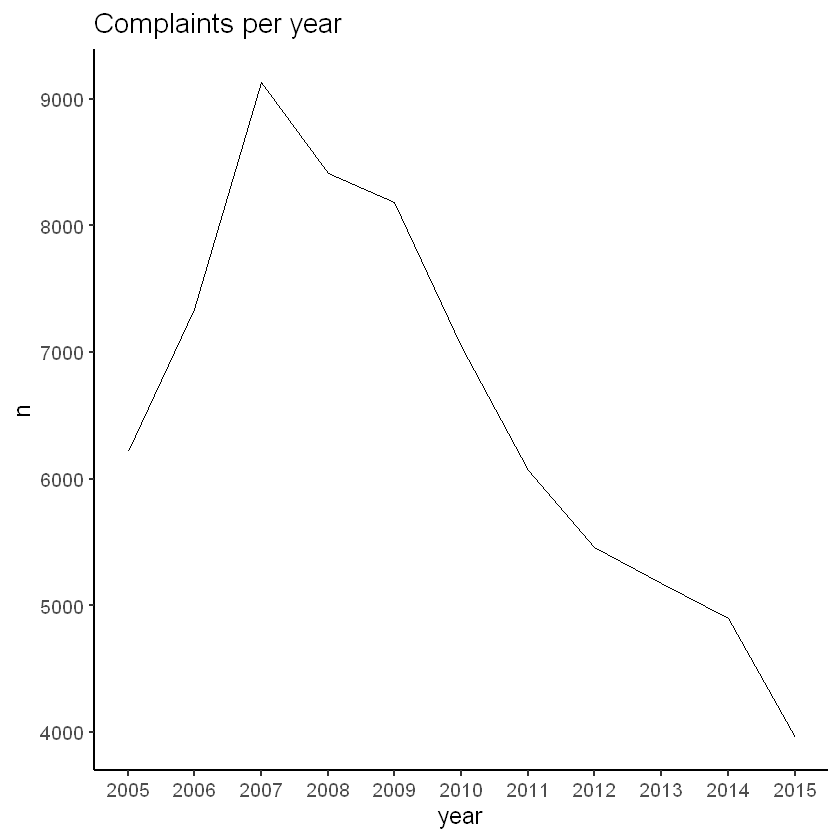

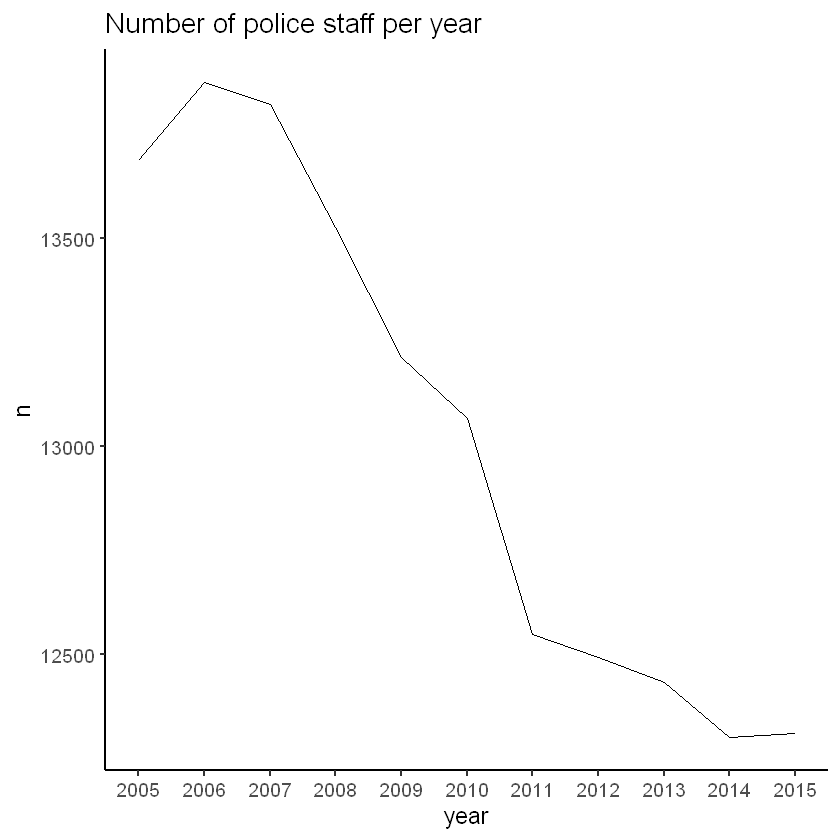

In [16]:
# Complaints by year
complaints_all_staff %>% 
    group_by(year) %>%
    summarize(n = sum(complaints_per_year)) %>%
    ggplot(aes(x = year, y = n)) + 
    geom_line() + 
    ggtitle("Complaints per year") + 
    scale_x_continuous(breaks = 2005:2015)

# number of police staff/records per year (included in analysis)
complaints_all_staff %>% 
    count(year) %>%
    ggplot(aes(x = year, y = n)) + 
    geom_line() + 
    ggtitle("Number of police staff per year") + 
    scale_x_continuous(breaks = 2005:2015)

`summarise()` ungrouping output (override with `.groups` argument)



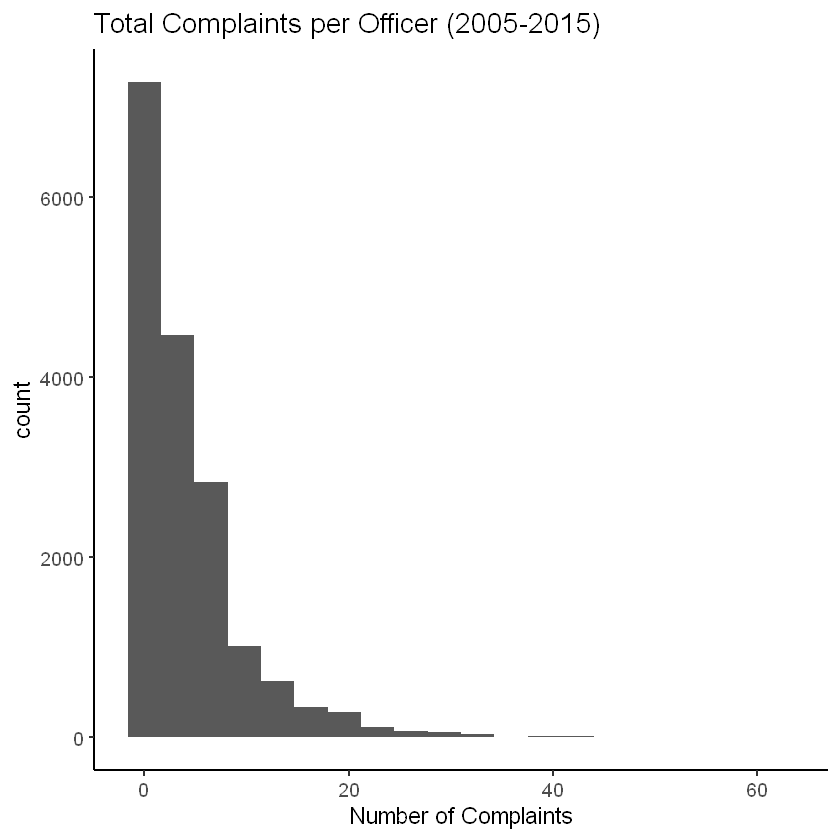

In [17]:
#Histogram of total complaints per officer - total complaints does not match because one complaint can be tied to multiple officers
complaints_all_staff %>% 
    group_by(link_UID) %>%
    summarize(n = sum(complaints_per_year)) %>%
    ggplot(aes(x = n)) +
    labs(x = "Number of Complaints") + 
    ggtitle("Total Complaints per Officer (2005-2015)") +
    geom_histogram(bins = 20)

`summarise()` regrouping output by 'link_UID' (override with `.groups` argument)



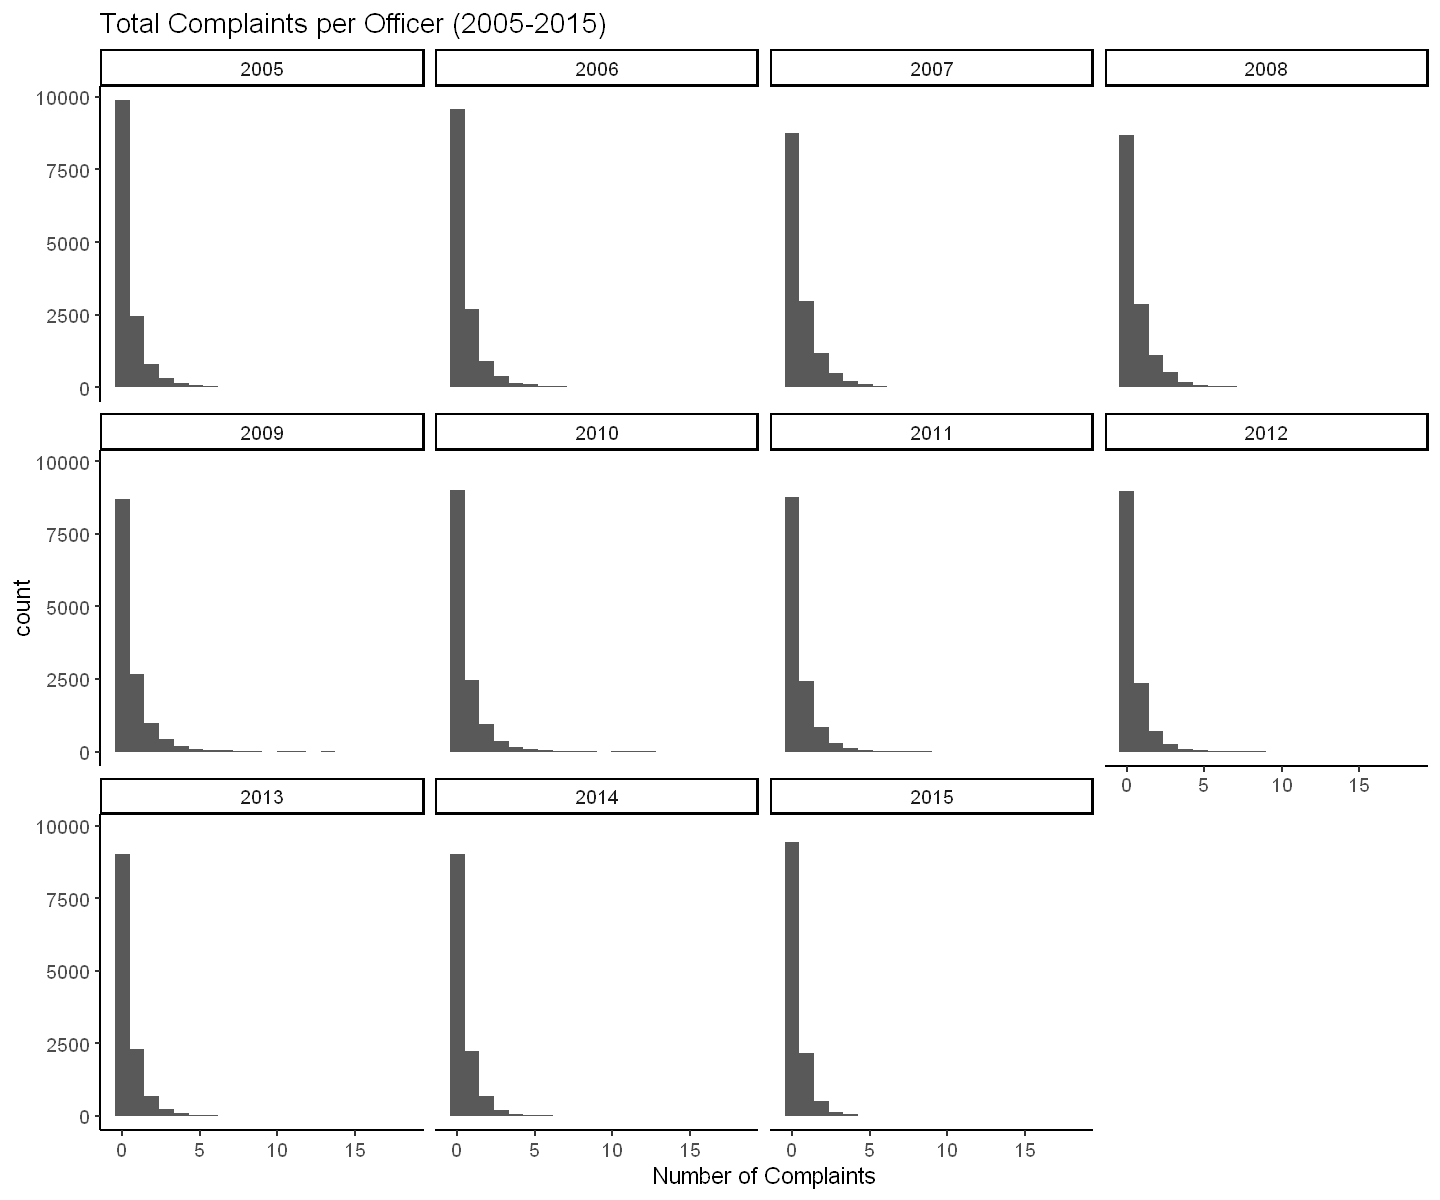

In [20]:
options(repr.plot.width=12, repr.plot.height=10)

#Faceted per year histogram
complaints_all_staff %>% 
    group_by(link_UID, year) %>%
    summarize(n = sum(complaints_per_year)) %>%
    ggplot(aes(x = n)) +
    labs(x = "Number of Complaints") + 
    ggtitle("Total Complaints per Officer (2005-2015)") +
    geom_histogram(bins = 20) +
    facet_wrap(~year, nrow=3)

`summarise()` ungrouping output (override with `.groups` argument)



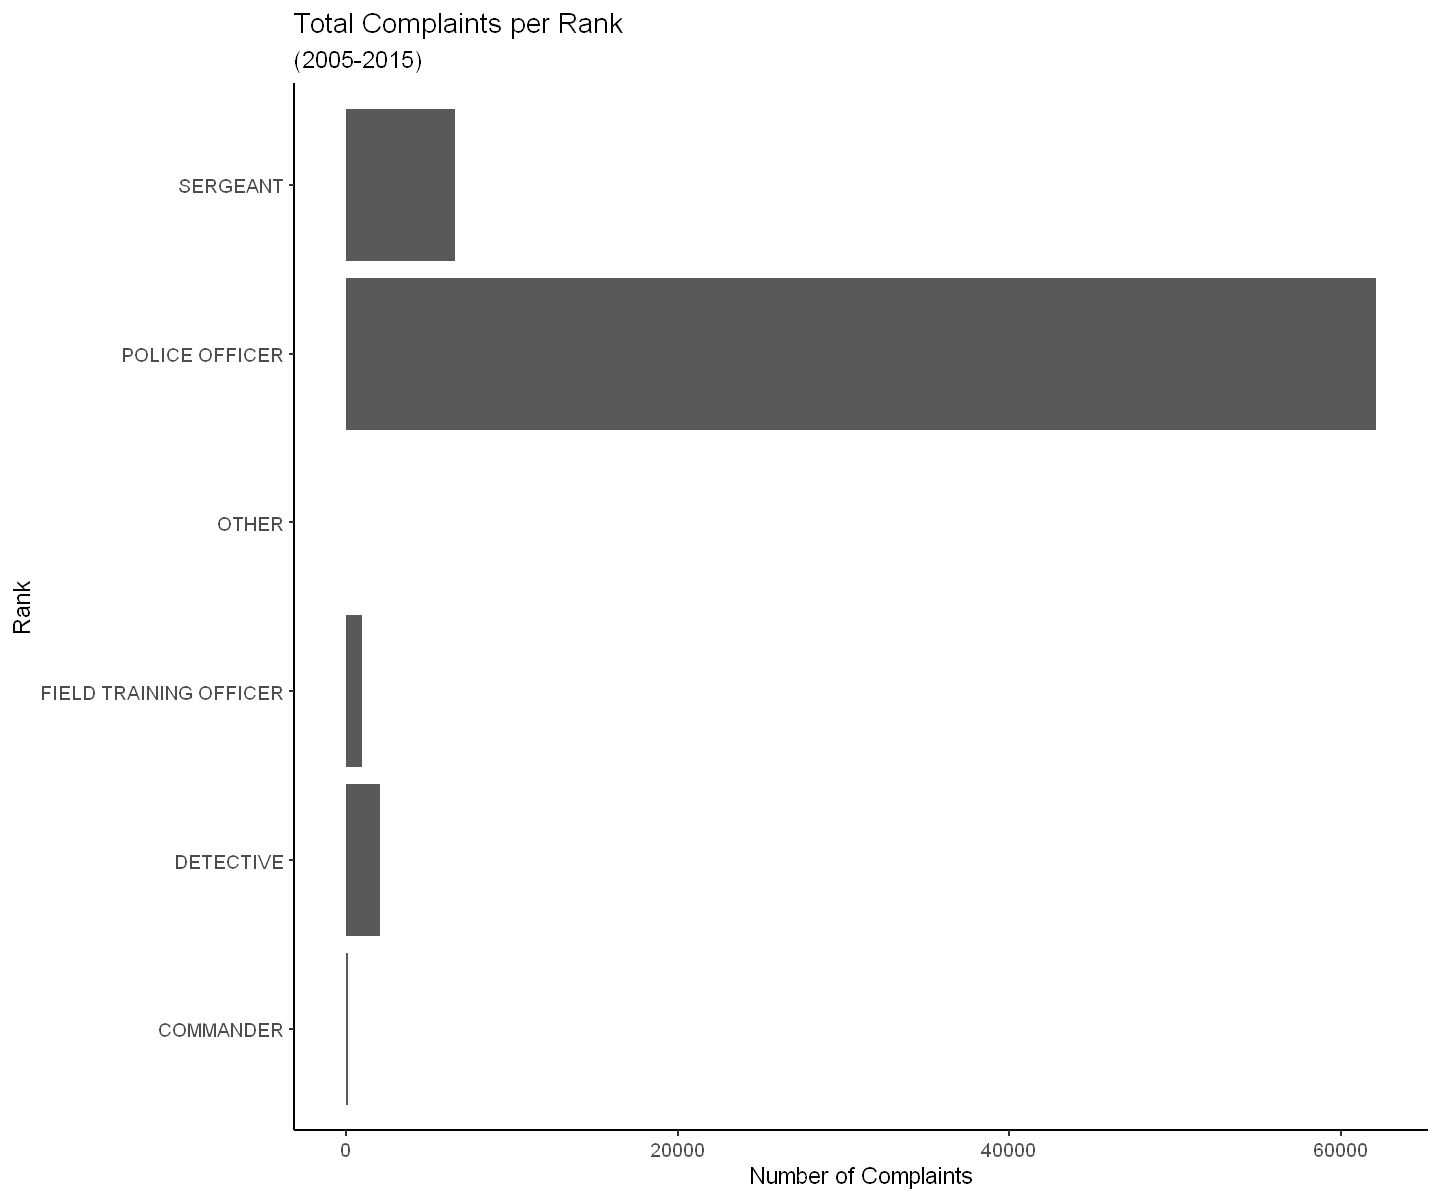

In [21]:
# complaints by officer rank
complaints_all_staff %>% 
    group_by(cleaned_rank) %>%
    summarize(n = sum(complaints_per_year)) %>%
    mutate(cleaned_rank = ifelse(n < 100, "OTHER", as.character(cleaned_rank))) %>%
    ggplot(aes(y=cleaned_rank, x = n)) +
    labs(x = "Number of Complaints", y = "Rank", title = "Total Complaints per Rank", subtitle = "(2005-2015)") + 
    geom_col()

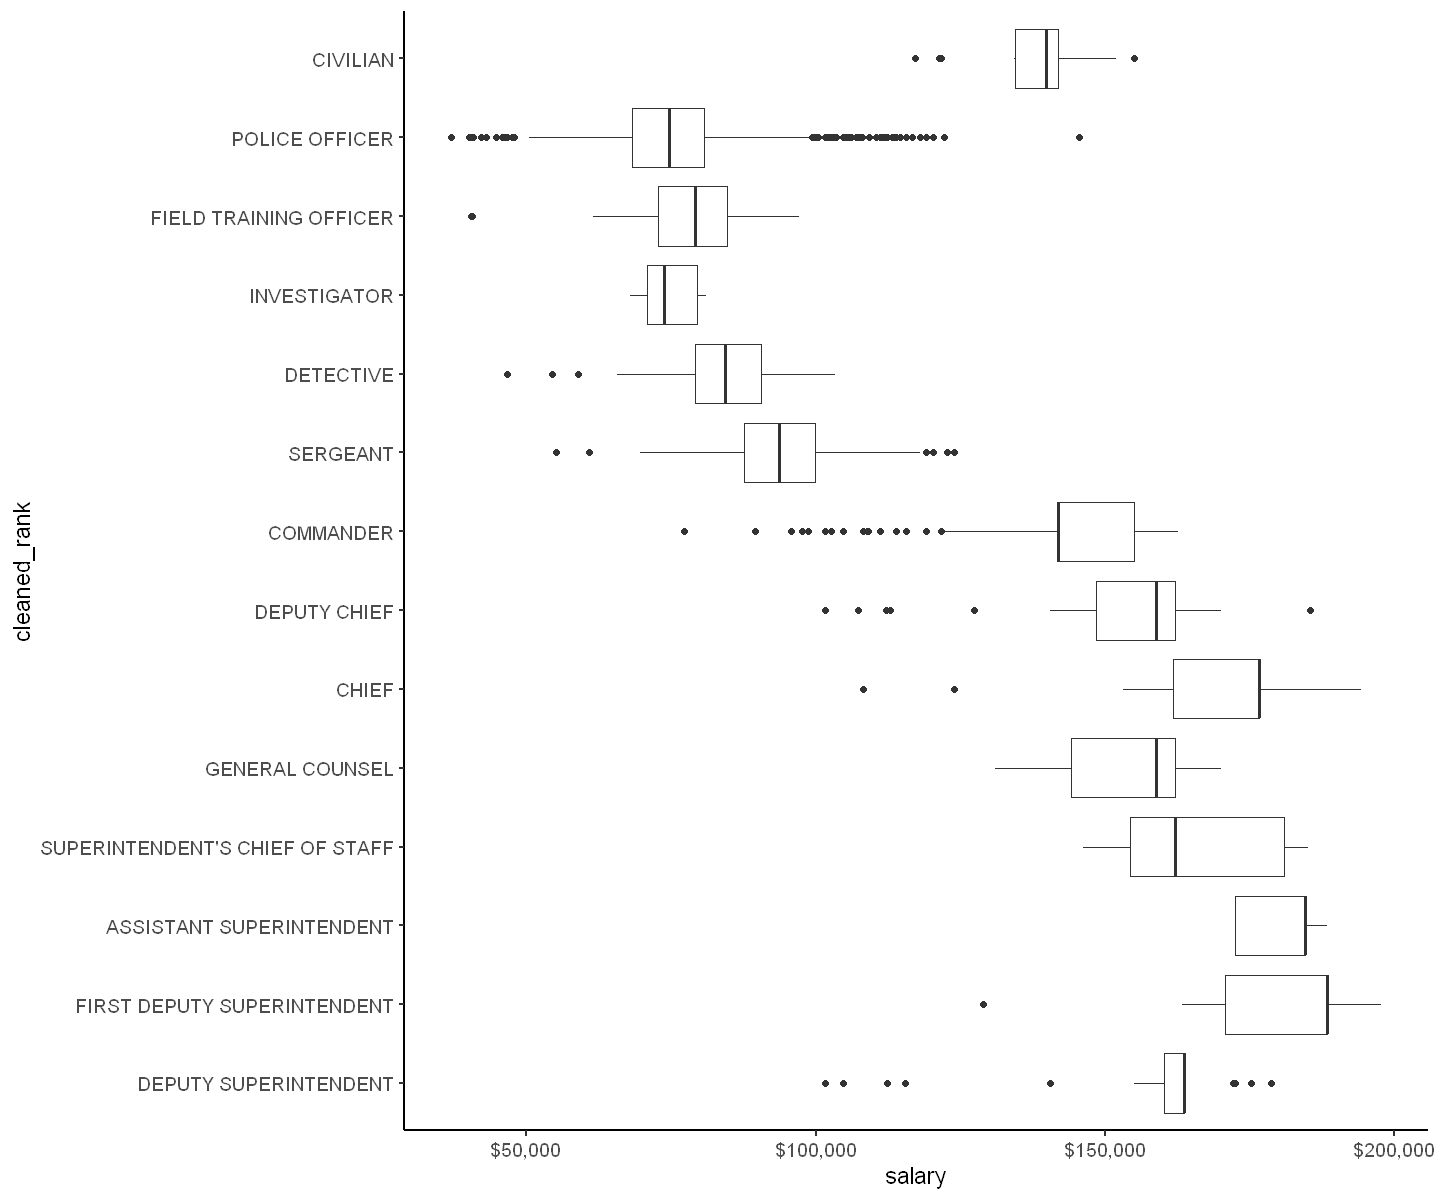

In [22]:
# Boxplot
complaints_all_staff %>% 
    ggplot(aes(x = salary, y = cleaned_rank)) +
  geom_boxplot() + 
  scale_x_continuous(labels = scales::label_dollar())

`summarise()` ungrouping output (override with `.groups` argument)

`geom_smooth()` using formula 'y ~ x'



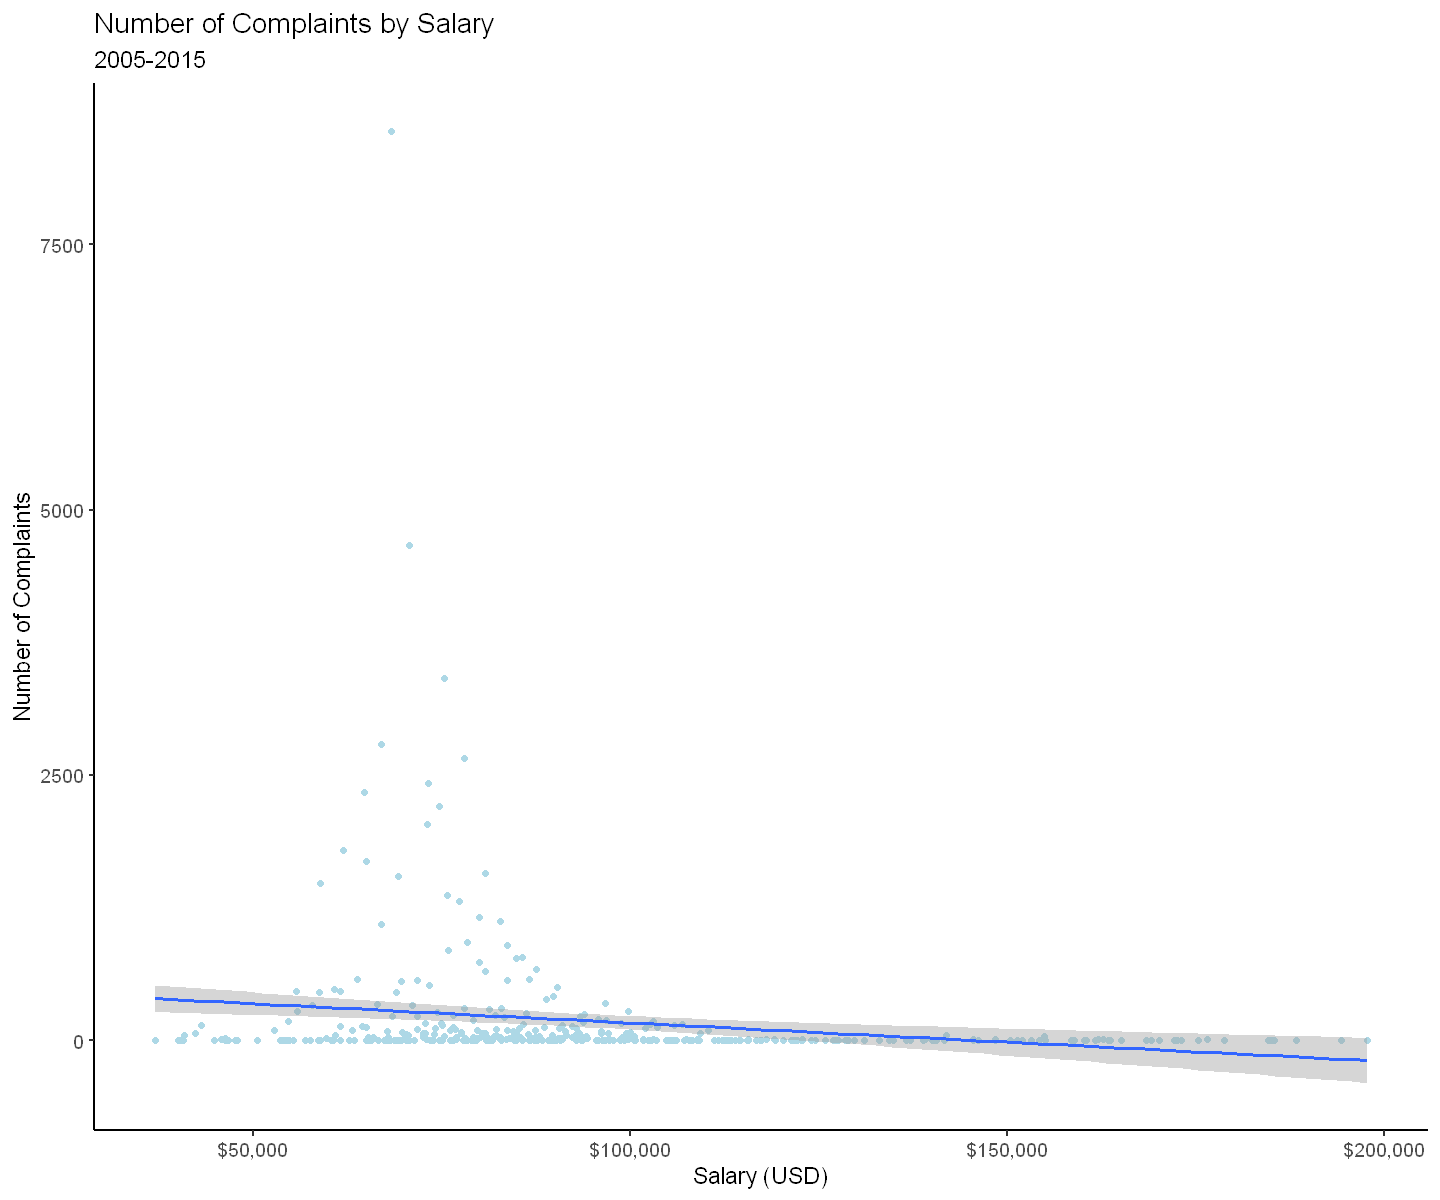

In [23]:
# complaints per salary
complaints_all_staff %>% 
    group_by(salary) %>% 
    summarize(num_complaints = sum(complaints_per_year)) %>%
    ggplot(aes(x = salary, y = num_complaints)) + 
        geom_point(color="lightblue") +
        scale_x_continuous(labels = scales::label_dollar()) +
        labs(title = "Number of Complaints by Salary", subtitle = "2005-2015", x = "Salary (USD)", y = "Number of Complaints") + 
        geom_smooth(method=lm)

In [ ]:
# calculate a complaint rate
compaint_rates <- df_merged %>%
    group_by(salary, year) %>%
    summarize(num_complaints = sum(!is.na(cr_id)), num_employees = sum(!is.na(UID))) %>%
    mutate(complaint_rate = num_complaints / num_employees)

#compaint_rates
ggplot(compaint_rates, aes(x = salary, y = complaint_rate)) + 
        geom_point(color = "lightblue") +
        scale_x_continuous(labels = scales::label_dollar()) + 
        labs(title="Complaint Rate by Salary", subtitle = "2005-2015", x = "Salary USD", y = "Complaint Rate (# complaints/ # employees)") + 
        geom_smooth(method=lm)

Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
"Removed 11550 rows containing missing values"
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
"Removed 11628 rows containing missing values"
Warning message:
"Removed 11550 rows containing missing values (geom_point)."
Warning message:
"Removed 11550 rows containing non-finite values (stat_density)."
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
"Removed 11628 rows containing missing values"
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
"Removed 11550 rows containing missing values"
Warning message:
"Removed 11628 rows containing missing values (geom_point)."
Warning message:
"Removed 11628 rows containing missing values (geom_point)."
Warning message:
"Removed 11628 rows containing non-finite values (stat_density)."
Warning message in ggally_statistic(data = data, mapping = mapping, na.r

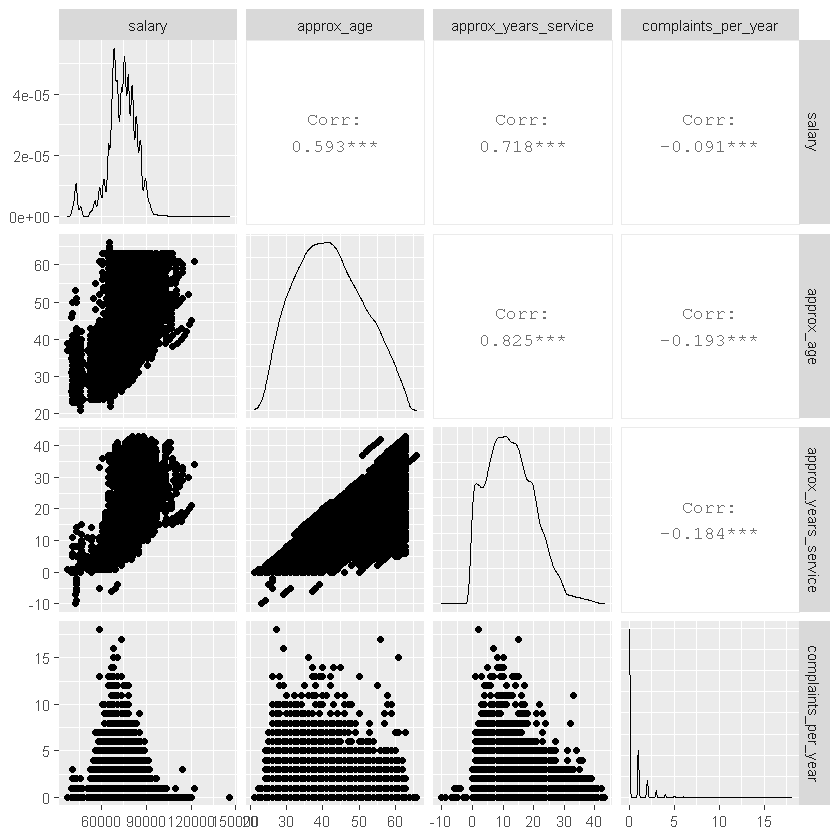

In [63]:
complaints_all_staff %>%
    filter(cleaned_rank == "POLICE OFFICER") %>%
    select(salary, approx_age, approx_years_service, complaints_per_year) %>% 
    GGally::ggpairs(progress=FALSE)